# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import graphviz as gv
import matplotlib.pyplot as plt
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import math
from cycler import cycler

In [2]:
df = pd.read_csv('/Users/rita/Desktop/МО/3 и 4 лабы/smoking_driking_dataset.csv')
df.head(5)

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,Male,35,170,75,90.0,1.0,1.0,1.0,1.0,120.0,...,126.0,92.0,17.1,1.0,1.0,21.0,35.0,40.0,1.0,Y
1,Male,30,180,80,89.0,0.9,1.2,1.0,1.0,130.0,...,148.0,121.0,15.8,1.0,0.9,20.0,36.0,27.0,3.0,N
2,Male,40,165,75,91.0,1.2,1.5,1.0,1.0,120.0,...,74.0,104.0,15.8,1.0,0.9,47.0,32.0,68.0,1.0,N
3,Male,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,...,104.0,106.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,N
4,Male,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,...,117.0,104.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,N


# Проверка на дубликаты с последующим удалением

In [3]:
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)
df = df.dropna()
df = df.drop_duplicates()
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (26, 24)
number of duplicate rows:  (0, 24)


# Преобразование данных
### Замена 
    Male -> 1|Female -> 0

    Y -> 1|N -> 0

In [4]:
df_copy = pd.get_dummies(df[['sex', 'DRK_YN']])

transformed_df = df.join(df_copy)

### Удаление лишних столбцов

In [5]:
transformed_df.drop(['sex', 'DRK_YN','sex_Female', 'DRK_YN_N', 'hear_left', 
                     'hear_right', 'urine_protein', 'sight_right', 'sight_left'], 
                    axis=1, inplace=True)
transformed_df=transformed_df.rename(columns={"sex_Male": "sex", "DRK_YN_Y": "DRK_YN"})
transformed_df.drop(['DRK_YN'], axis=1, inplace=True)
transformed_df["sex"] = transformed_df["sex"].astype(int)

In [6]:
transformed_df.shape
Q1 = transformed_df.quantile(0.25)
Q3 = transformed_df.quantile(0.75)
IQR = Q3 - Q1
transformed_df = transformed_df[~((transformed_df < (Q1 - 1.5 * IQR)) 
                                  |(transformed_df > (Q3 + 1.5 * IQR))).any(axis=1)]
transformed_df.shape

(712905, 18)

In [7]:
smk_df = transformed_df['SMK_stat_type_cd']
smk_df.replace(1, 0, inplace=True)
smk_df.replace(2, 1, inplace=True)
smk_df.replace(3, 2, inplace=True)
transformed_df.drop(['SMK_stat_type_cd'], axis=1, inplace=True)
transformed_df = pd.concat([transformed_df, smk_df], axis=1, join='inner')
transformed_df = transformed_df[:10000]
display(transformed_df)

,age,height,weight,waistline,SBP,DBP,BLDS,tot_chole,HDL_chole,LDL_chole,triglyceride,hemoglobin,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,sex,SMK_stat_type_cd
0,35,170,75,90.0,120.0,80.0,99.0,193.0,48.0,126.0,92.0,17.1,1.0,21.0,35.0,40.0,1,0.0
1,30,180,80,89.0,130.0,82.0,106.0,228.0,55.0,148.0,121.0,15.8,0.9,20.0,36.0,27.0,1,2.0
3,50,175,80,91.0,145.0,87.0,95.0,201.0,76.0,104.0,106.0,17.6,1.1,29.0,34.0,18.0,1,0.0
4,50,165,60,80.0,138.0,82.0,101.0,199.0,61.0,117.0,104.0,13.8,0.8,19.0,12.0,25.0,1,0.0
5,50,165,55,75.0,142.0,92.0,99.0,218.0,77.0,95.0,232.0,13.8,0.8,29.0,40.0,37.0,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13882,50,155,60,74.0,123.0,74.0,98.0,247.0,77.0,156.0,69.0,11.9,0.5,28.0,35.0,9.0,0,0.0
13883,60,170,65,75.0,126.0,80.0,111.0,186.0,56.0,101.0,142.0,15.6,0.7,27.0,15.0,35.0,1,2.0
13884,70,165,65,88.0,143.0,88.0,121.0,170.0,61.0,82.0,137.0,12.3,0.8,32.0,21.0,47.0,1,0.0
13886,55,170,65,81.0,113.0,83.0,104.0,196.0,41.0,106.0,244.0,14.3,1.3,29.0,31.0,24.0,1,0.0


In [8]:
len(transformed_df)

10000

# Построение тепловой карты

<Axes: >

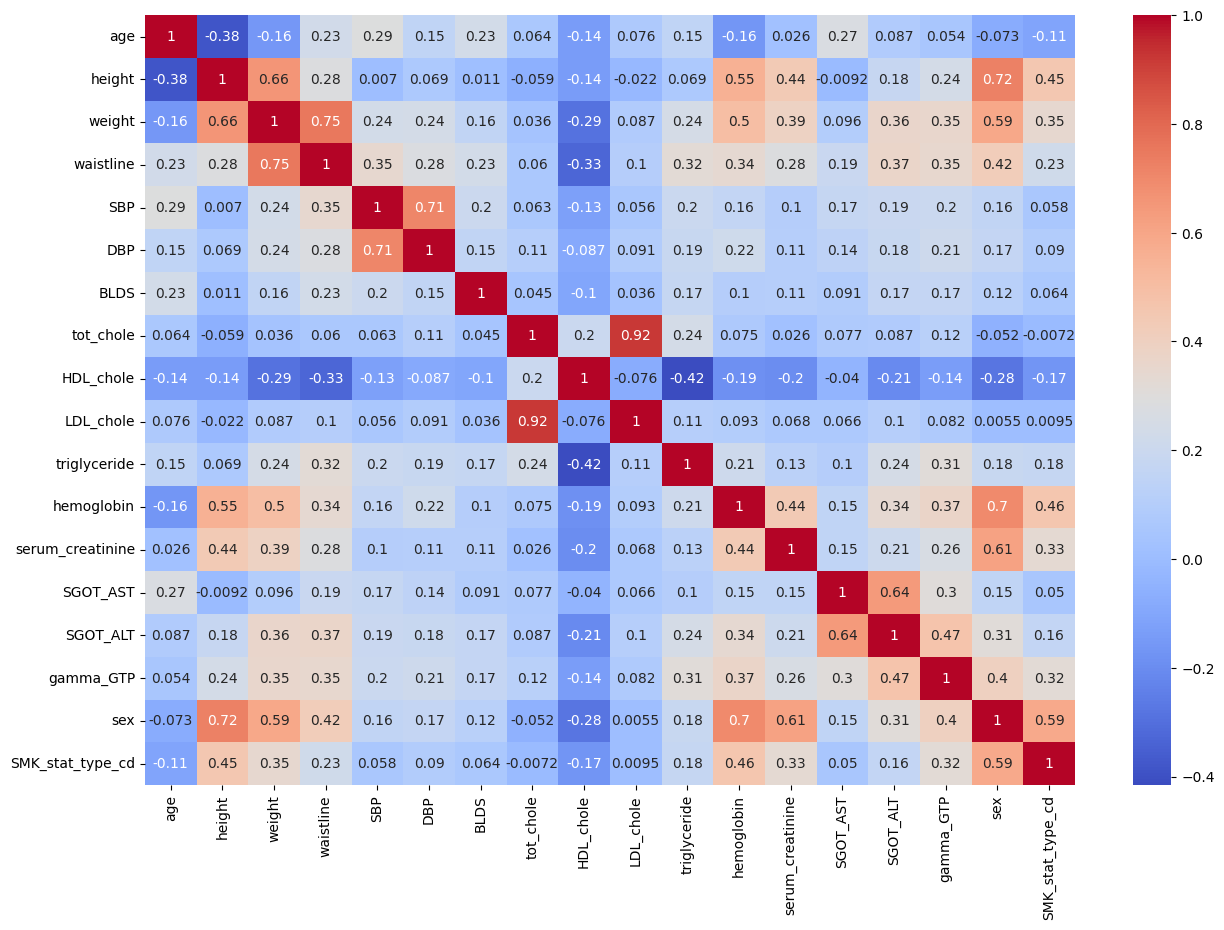

In [9]:
plt.figure(figsize=(15,10))
c= transformed_df.corr()
sns.heatmap(c,cmap="coolwarm",annot=True)

# Ящики с усами (выбросы)

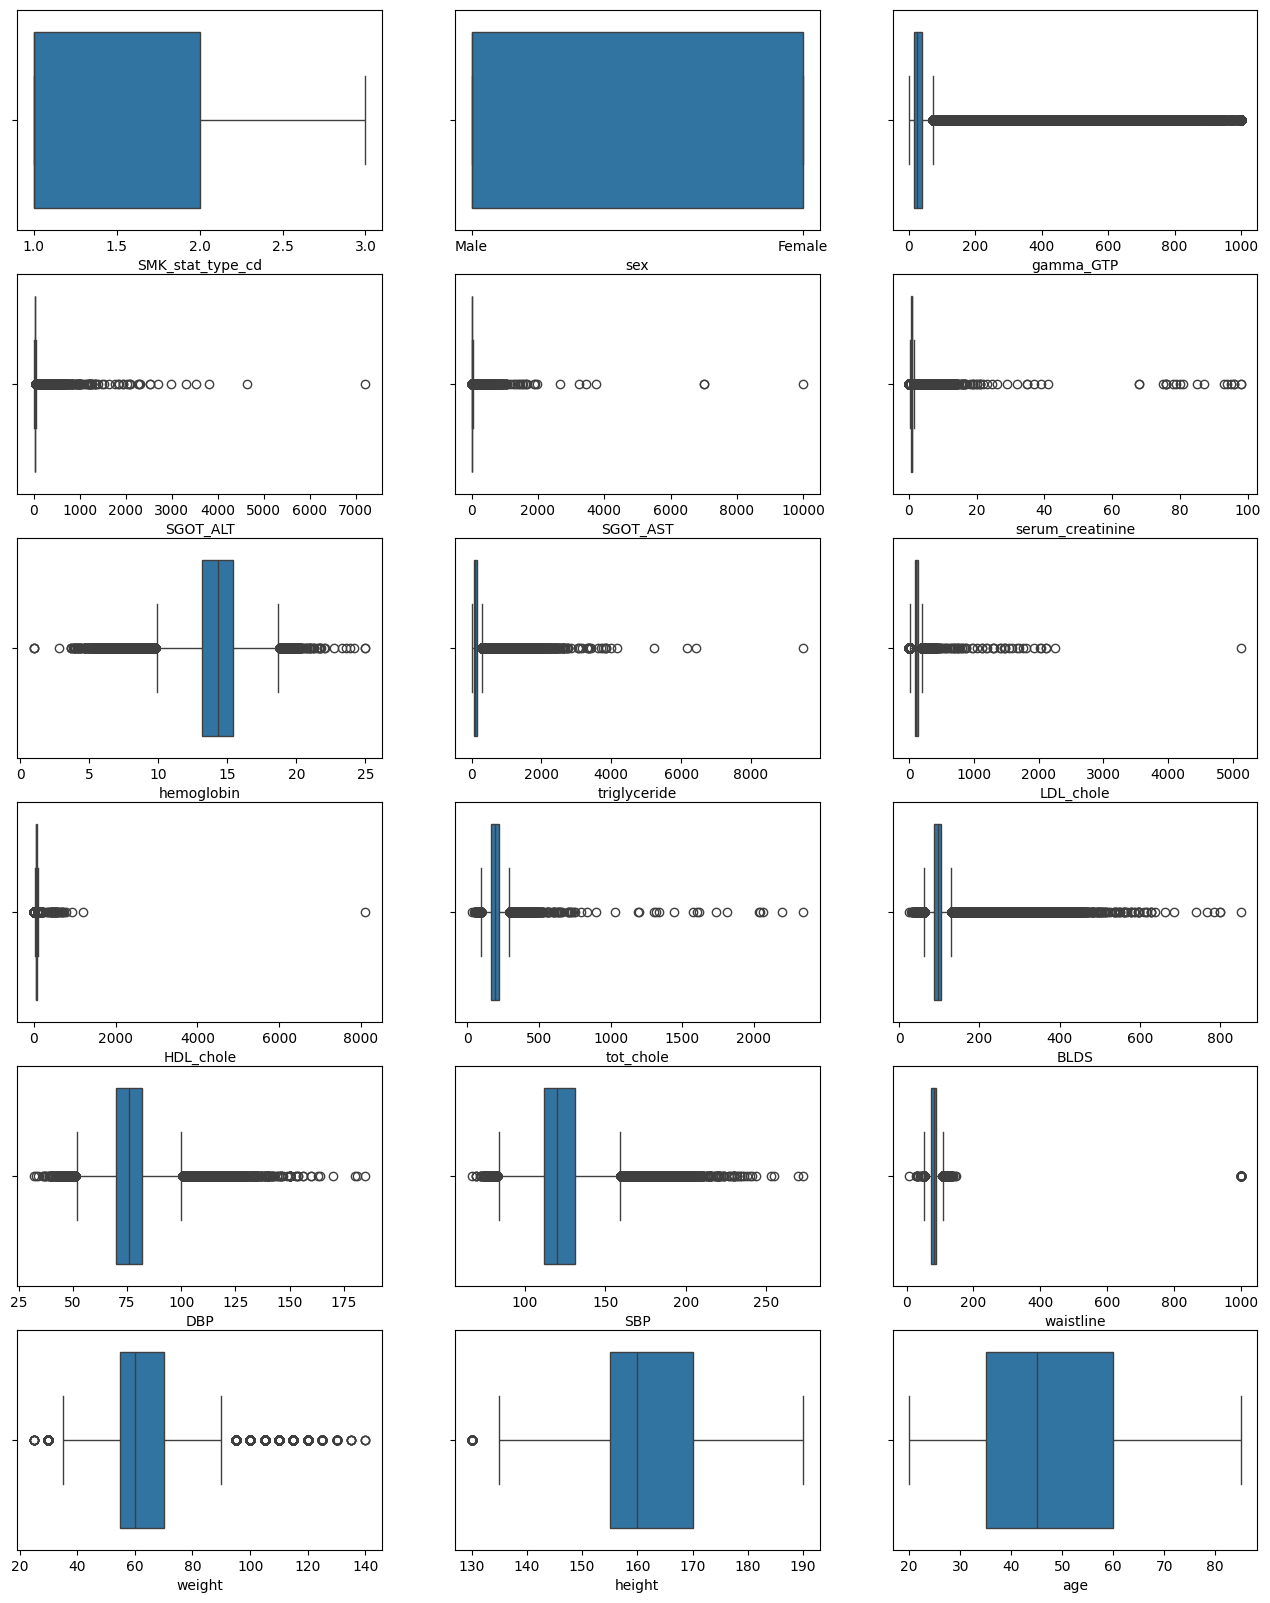

In [10]:
columns = list(transformed_df.columns)
fig, ax = plt.subplots(6, 3, figsize = (16, 20))
for i in range(6):
    k = 3
    for j in range(k):
        sns.boxplot(ax = ax[i,j], x = df[columns.pop()])

# Гистограммы

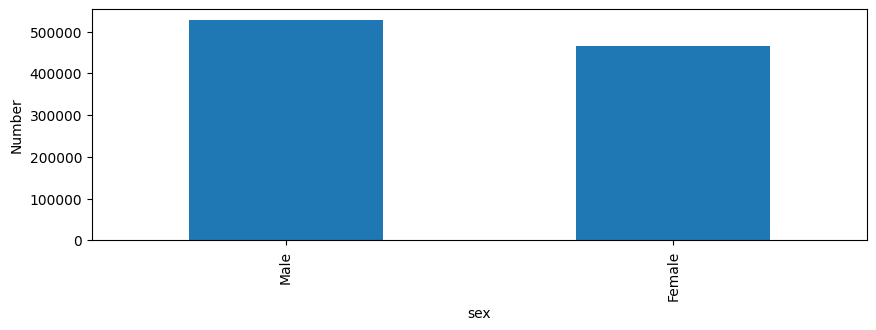

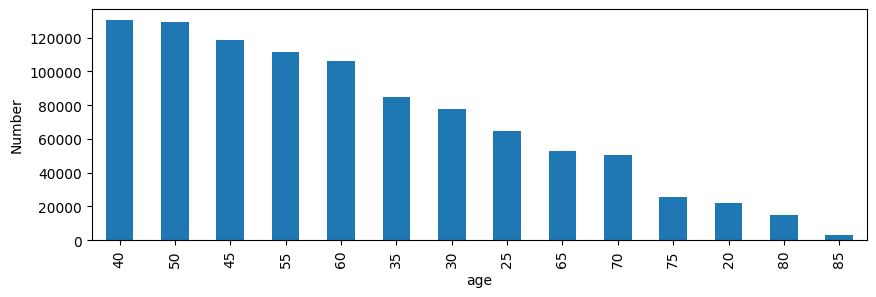

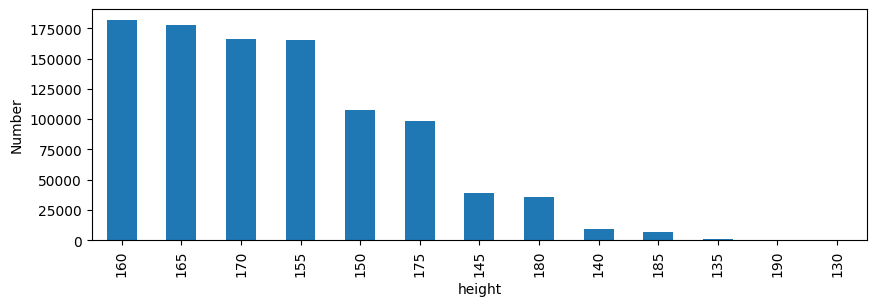

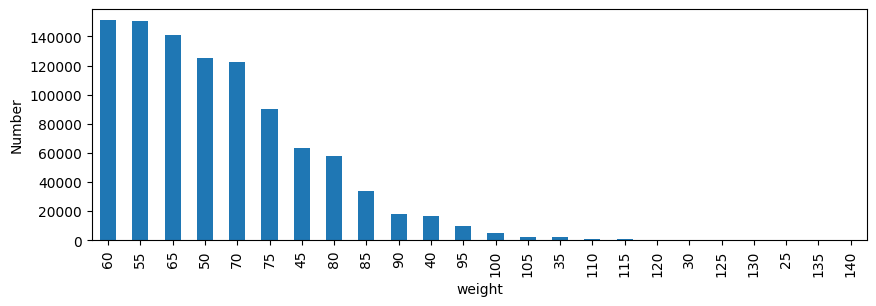

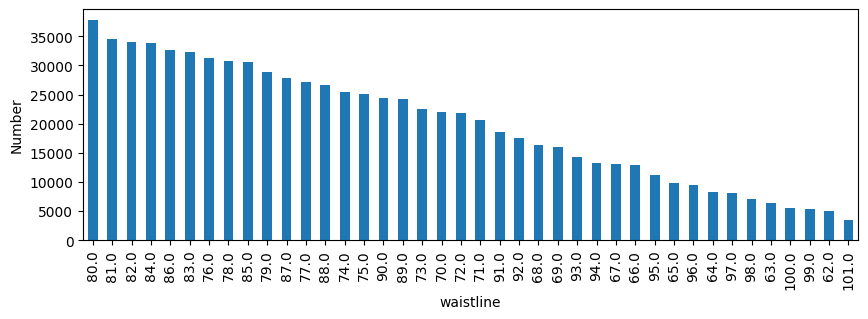

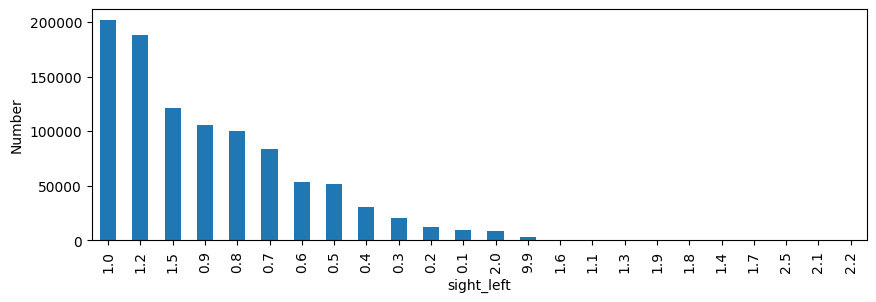

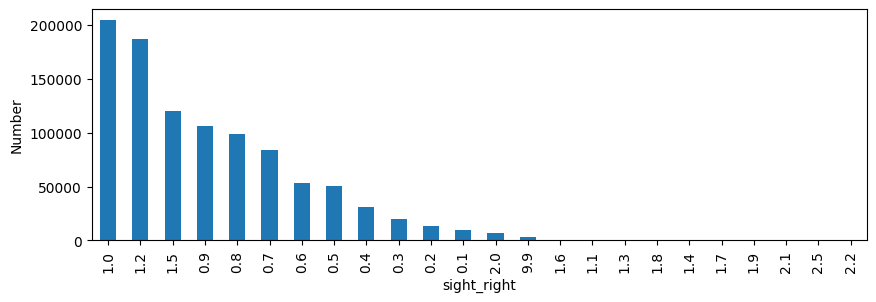

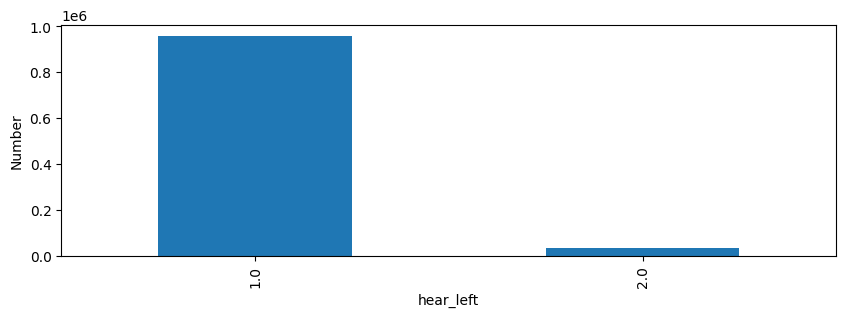

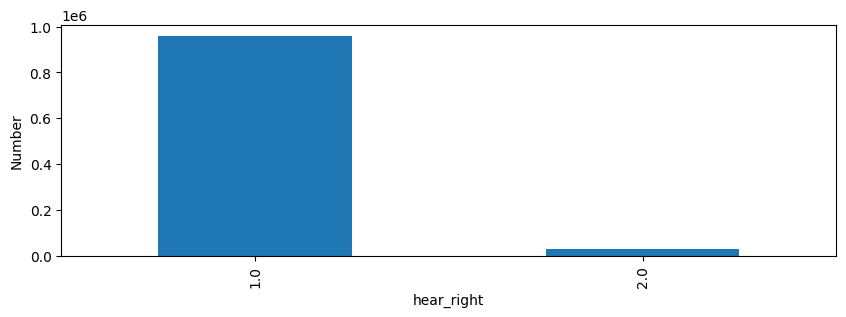

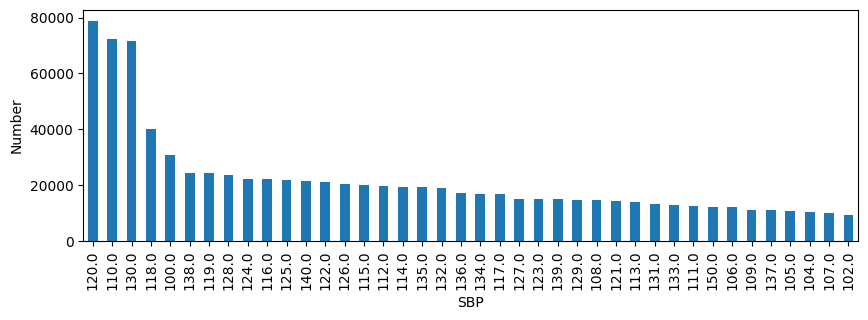

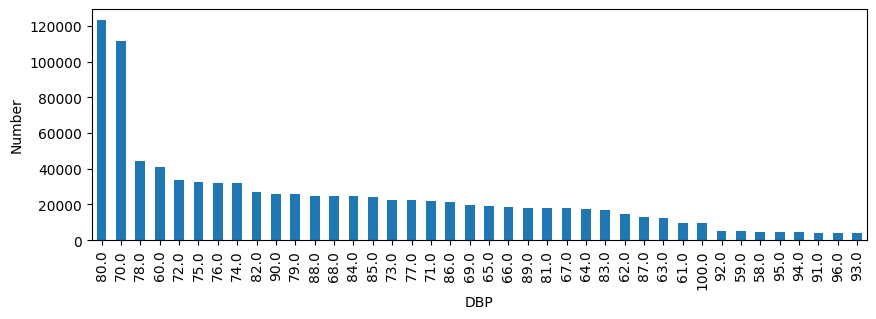

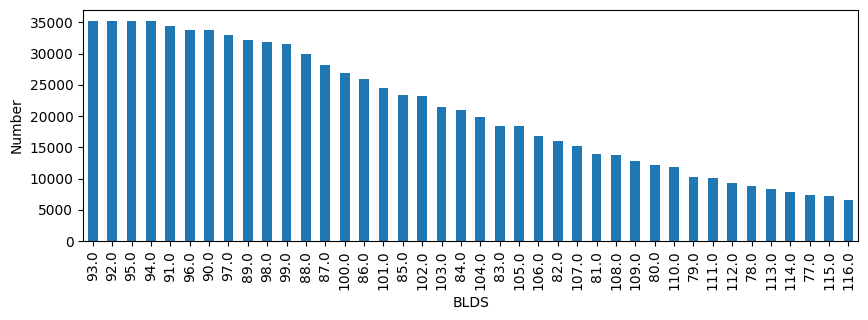

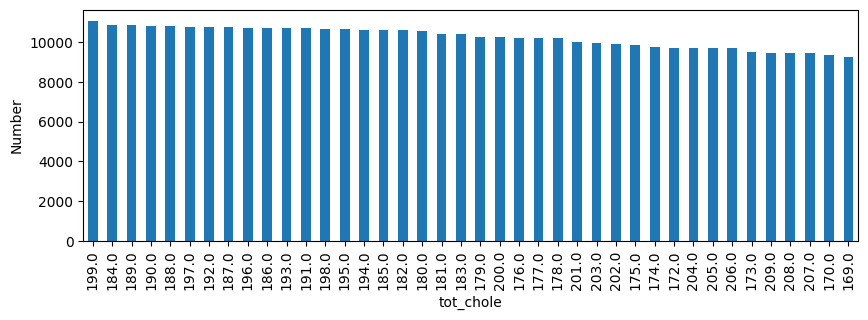

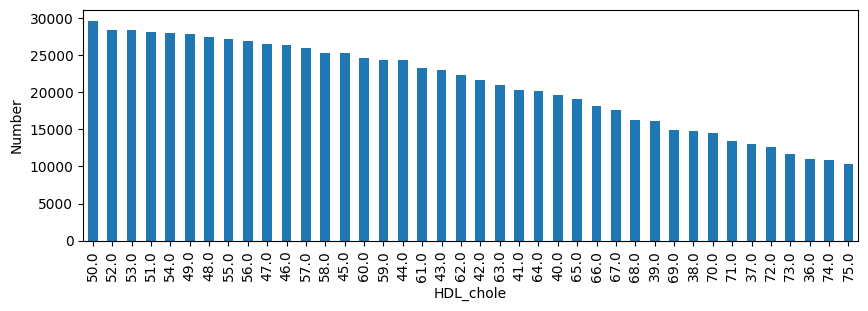

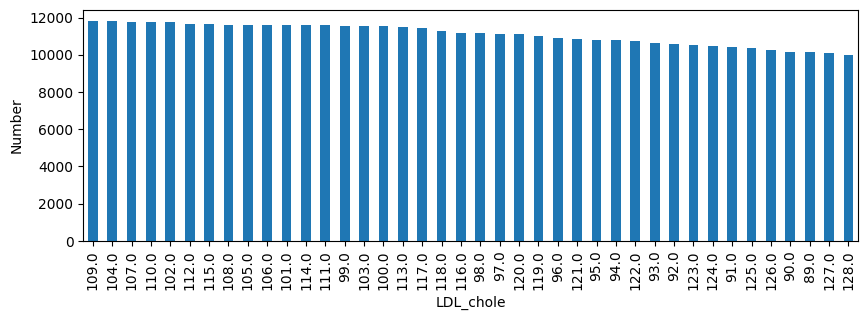

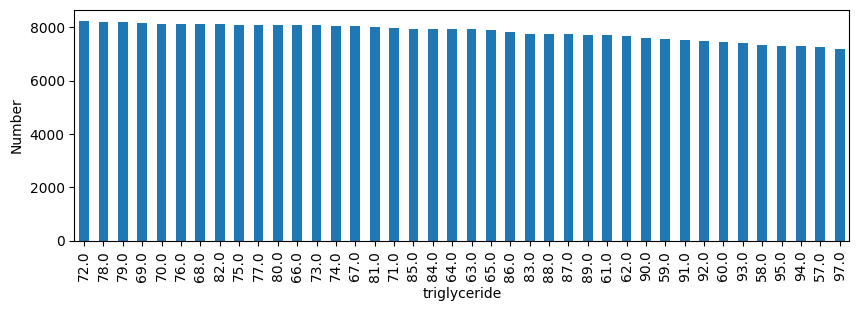

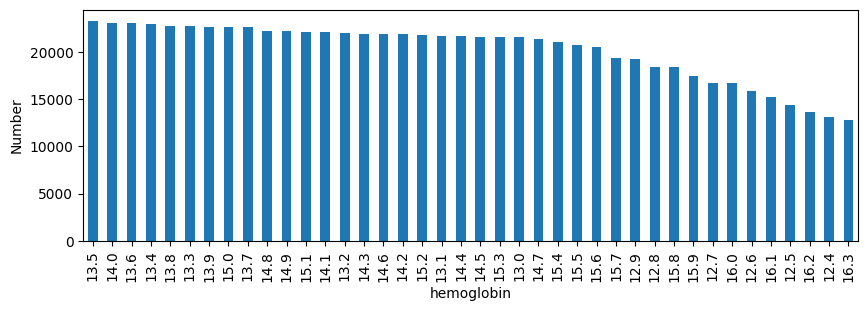

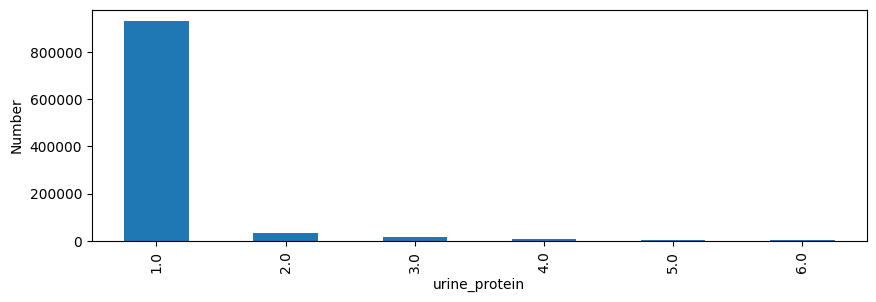

In [11]:
numOfRows = 40
for i in range(0, len(transformed_df.columns)):
    fig, ax = plt.subplots()
    df.iloc[:, i].value_counts().nlargest(40).plot(kind = 'bar', figsize=(10, 3), ax = ax)
    ax.set_ylabel('Number')
    ax.set_xlabel(df.columns[i])

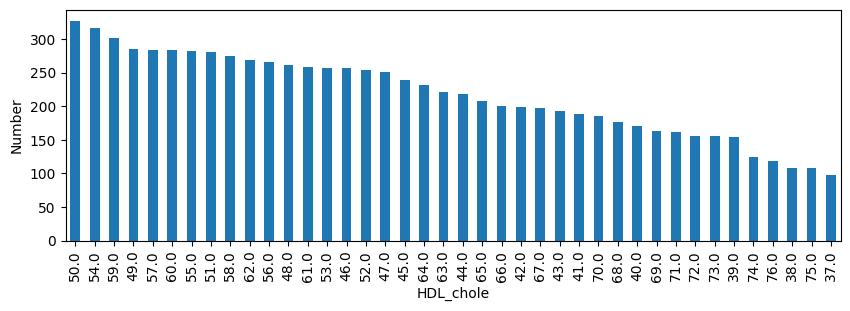

In [12]:
X = transformed_df.copy()
Y = X.pop('HDL_chole')
fig, ax = plt.subplots()
Y.value_counts().nlargest(numOfRows).plot(kind = 'bar', figsize=(10, 3), ax = ax)
ax.set_ylabel('Number')
ax.set_xlabel('HDL_chole')
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Линейная регрессия

Линейная регрессия - метод аппроксимации зависимостей между входными и выходными переменными на основе линейной модели.


In [13]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
lin_reg.coef_

array([-5.98333765e-03,  5.98573763e-03,  7.21509126e-03, -9.84284015e-03,
       -3.05438233e-03,  2.87979512e-03, -3.40629979e-04,  9.63285811e-01,
       -9.61311918e-01, -1.93583379e-01,  1.78780379e-02, -4.73862256e-01,
        1.87048878e-03, -6.05401534e-03,  2.46958471e-03, -9.93502685e-02,
       -2.55860730e-02])

In [35]:
y_pred = lin_reg.predict(x_test)

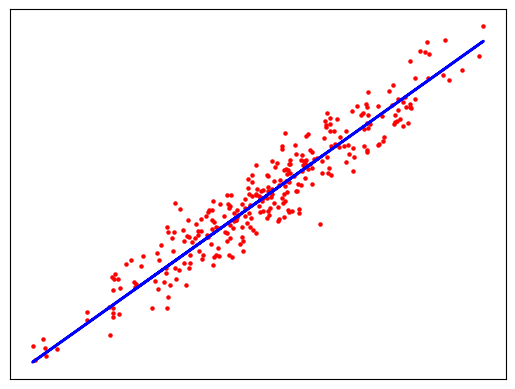

In [36]:
# plot outputs
plt.scatter(x_test, y_test, color='red', s=5)
plt.plot(x_test, y_pred, color='blue', linewidth=2)
 
plt.xticks(())
plt.yticks(())

plt.show()

Метрики:

Mean Absolute error - средняя абсолютная ошибка — это мера ошибок между парными наблюдениями, выражающими одно и то же явление

Mean Squared Error - среднеквадратичная ошибка - это функция риска, соответствующая ожидаемому значению квадрата потерь из-за ошибки.

R-squared - коэффициент детерминации — это доля дисперсии зависимой переменной, объясняемая рассматриваемой моделью зависимости, то есть объясняющими переменными.

In [15]:
data = []

MAE_lin_reg = mean_absolute_error(y_test, y_pred)
print("MAE_lin_reg = ", MAE_lin_reg)

MSE_lin_reg = mean_squared_error(y_test, y_pred)
print("MSE_lin_reg = ", MSE_lin_reg)

r2_lin_reg = r2_score(y_test, y_pred)
print("r2_lin_reg = ", r2_lin_reg)

data.append(
            {
                "Mean Absolute error": MAE_lin_reg,
                "Mean Squared Error": MSE_lin_reg,
                "R-squared": r2_lin_reg
            }
    )

MAE_lin_reg =  0.8210902280501897
MSE_lin_reg =  5.89560981758285
r2_lin_reg =  0.9662823197499886


# Lasso регрессия

Lasso - регрессия решает задачу минимизации среднеквадратичной ошибки с L1 - регуляризацией:
$$error(X,y,w)=\frac{1}{2}\sum_{i=1}^{l}(y_i - w^T*x_i)^2+\alpha\sum_{i=1}^{d}|w_i|$$
где $y = w^Tx$ - уравнение гиперплоскости, зависящее от параметров модели w, l - число объектов в выборке X, d - число признаков, y - значения целевого признака, a - коэффициент регуляризации.

In [16]:
lasso = Lasso(alpha=0.001)
lasso.fit(x_train, y_train)
lasso.coef_

array([-6.11279709e-03,  5.58429366e-03,  7.13046341e-03, -9.81211452e-03,
       -3.02323477e-03,  2.87373850e-03, -3.55726482e-04,  9.63339550e-01,
       -9.61362305e-01, -1.93588910e-01,  1.49580445e-02, -4.37950334e-01,
        1.66708957e-03, -5.91436661e-03,  2.39585963e-03, -9.20364474e-02,
       -2.46168367e-02])

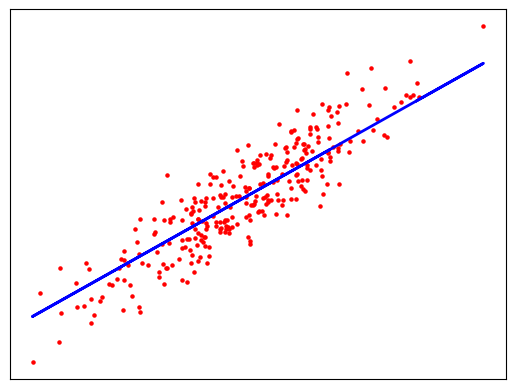

In [45]:
# plot outputs
y_pred = lasso.predict(x_test)
plt.scatter(x_test, y_test, color='red', s=5)
plt.plot(x_test, y_pred, color='blue', linewidth=2)
 
plt.xticks(())
plt.yticks(())

plt.show()

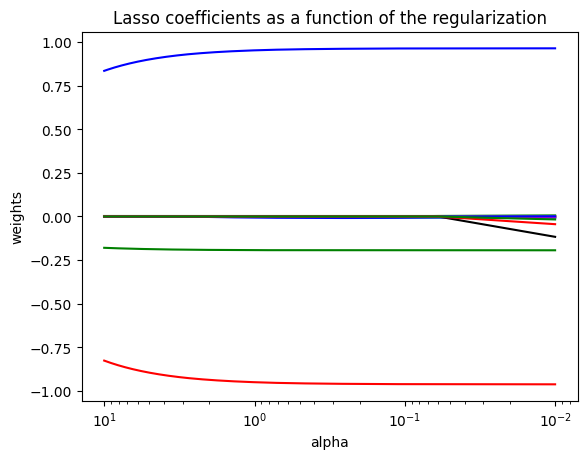

In [17]:
n_alphas = 200
alphas = np.linspace(0.01, 10, n_alphas)
model = Lasso()

coefs = []
for a in alphas:
    model.set_params(alpha=a)
    model.fit(x_train, y_train)
    coefs.append(model.coef_)

ax = plt.gca()
ax.set_prop_cycle(cycler("color", ["b", "r", "g", "c", "k", "y", "m"]))

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Lasso coefficients as a function of the regularization")
plt.axis("tight")
plt.show();

Alpha - коэффициент регуляризации, weight - веса

In [18]:
lasso_cv = LassoCV(alphas=alphas, cv=3, random_state=17)
lasso_cv.fit(X, Y)

LassoCV(alphas=array([ 0.01      ,  0.06020101,  0.11040201,  0.16060302,  0.21080402,
        0.26100503,  0.31120603,  0.36140704,  0.41160804,  0.46180905,
        0.51201005,  0.56221106,  0.61241206,  0.66261307,  0.71281407,
        0.76301508,  0.81321608,  0.86341709,  0.91361809,  0.9638191 ,
        1.0140201 ,  1.06422111,  1.11442211,  1.16462312,  1.21482412,
        1.26502513,  1.31522613,  1.36542714,  1.41562814,  1.46582915,
        1.5160...
        8.29316583,  8.34336683,  8.39356784,  8.44376884,  8.49396985,
        8.54417085,  8.59437186,  8.64457286,  8.69477387,  8.74497487,
        8.79517588,  8.84537688,  8.89557789,  8.94577889,  8.9959799 ,
        9.0461809 ,  9.09638191,  9.14658291,  9.19678392,  9.24698492,
        9.29718593,  9.34738693,  9.39758794,  9.44778894,  9.49798995,
        9.54819095,  9.59839196,  9.64859296,  9.69879397,  9.74899497,
        9.79919598,  9.84939698,  9.89959799,  9.94979899, 10.        ]),
        cv=3, random_state=17)

In [19]:
lasso_cv.coef_

array([-9.82187655e-03,  0.00000000e+00, -0.00000000e+00, -4.32200772e-03,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  9.60834439e-01,
       -9.57844666e-01, -1.93043348e-01, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -5.55322845e-04,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00])

In [20]:
lasso_cv.alpha_

0.1606030150753769

In [21]:
lasso = Lasso(alpha=lasso_cv.alpha_)
lasso.fit(x_train, y_train)
y_pred = lasso.predict(x_test)

In [22]:
MAE_las = mean_absolute_error(y_test, y_pred)
print("MAE_las = ", MAE_las)

MSE_las = mean_squared_error(y_test, y_pred)
print("MSE_las = ", MSE_las)

r2_las = r2_score(y_test, y_pred)
print("r2_las = ", r2_las)

data.append(
            {
                "Mean Absolute error": MAE_las,
                "Mean Squared Error": MSE_las,
                "R-squared": r2_las
            }
    )

MAE_las =  0.8238596666259459
MSE_las =  5.889939962017436
r2_las =  0.966314746315337


# Ridge регрессия

Ridge - регрессия (или гребневая регрессия) решает задачу минимизации среднеквадратичной ошибки с L2 - регуляризацией:
$$error(X,y,w)=\frac{1}{2}\sum_{i=1}^{l}(y_i - w^T*x_i)^2+\alpha\sum_{i=1}^{d}w_i^2$$
где $y = w^Tx$ - уравнение гиперплоскости, зависящее от параметров модели w, l - число объектов в выборке X, d - число признаков, y - значения целевого признака, a - коэффициент регуляризации.

In [23]:
n_alphas = 200
ridge_alphas = np.logspace(-2, 60, n_alphas)
ridge_cv = RidgeCV(alphas=ridge_alphas, scoring="neg_mean_squared_error", cv=3)
ridge_cv.fit(X, Y)

RidgeCV(alphas=array([1.00000000e-02, 2.04907469e-02, 4.19870708e-02, 8.60346442e-02,
       1.76291412e-01, 3.61234270e-01, 7.40196000e-01, 1.51671689e+00,
       3.10786619e+00, 6.36824994e+00, 1.30490198e+01, 2.67384162e+01,
       5.47890118e+01, 1.12266777e+02, 2.30043012e+02, 4.71375313e+02,
       9.65883224e+02, 1.97916687e+03, 4.05546074e+03, 8.30994195e+03,
       1.70276917e+04, 3.48910121e+0...
       6.82607183e+52, 1.39871310e+53, 2.86606762e+53, 5.87278661e+53,
       1.20337784e+54, 2.46581108e+54, 5.05263107e+54, 1.03532184e+55,
       2.12145178e+55, 4.34701316e+55, 8.90735464e+55, 1.82518349e+56,
       3.73993730e+56, 7.66341087e+56, 1.57029012e+57, 3.21764175e+57,
       6.59318827e+57, 1.35099352e+58, 2.76828663e+58, 5.67242607e+58,
       1.16232247e+59, 2.38168555e+59, 4.88025158e+59, 1.00000000e+60]),
        cv=3, scoring='neg_mean_squared_error')

In [24]:
ridge_cv.alpha_

471.3753134116729

In [25]:
ridge_cv.coef_

array([-9.18296162e-03,  8.47265275e-03, -3.75941130e-04, -5.48572722e-03,
        4.03411821e-04,  3.78898463e-04, -4.56139166e-04,  9.61442571e-01,
       -9.58407711e-01, -1.92993703e-01, -1.42423187e-02, -1.68191368e-01,
        2.38457156e-03, -3.67585360e-03,  2.71588376e-03, -8.50269127e-02,
       -1.25413446e-02])

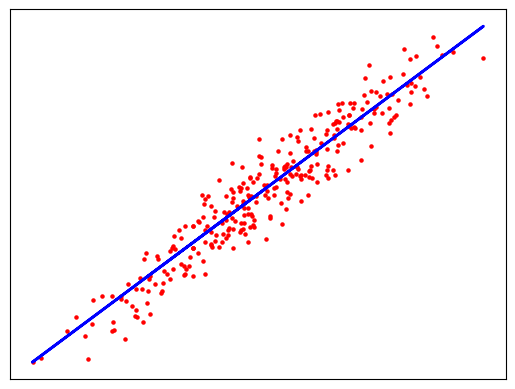

In [67]:
rid = Ridge(alpha=ridge_cv.alpha_)
rid.fit(x_train, y_train)
y_pred = rid.predict(x_test)
# plot outputs
plt.scatter(x_test, y_test, color='red', s=5)
plt.plot(x_test, y_pred, color='blue', linewidth=2)
 
plt.xticks(())
plt.yticks(())

plt.show()

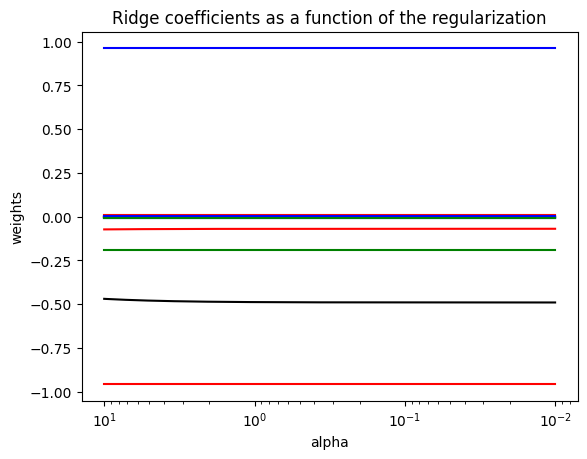

In [26]:
n_alphas = 200
ridge_alphas = np.logspace(-2, 6, n_alphas)
model = Ridge()

coefs = []
for a in alphas:
    model.set_params(alpha=a)
    model.fit(X, Y)
    coefs.append(model.coef_)

ax = plt.gca()
ax.set_prop_cycle(cycler("color", ["b", "r", "g", "c", "k", "y", "m"]))

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

In [27]:
rid = Ridge(alpha=ridge_cv.alpha_)
rid.fit(x_train, y_train)
y_pred = rid.predict(x_test)

In [28]:
MAE_rid = mean_absolute_error(y_test, y_pred)
print("MAE_rid = ", MAE_rid)

MSE_rid = mean_squared_error(y_test, y_pred)
print("MSE_rid = ", MSE_rid)

r2_rid = r2_score(y_test, y_pred)
print("r2_rid = ", r2_rid)

data.append(
            {
                "Mean Absolute error": MAE_rid,
                "Mean Squared Error": MSE_rid,
                "R-squared": r2_rid
            }
    )

MAE_rid =  0.8215127360325363
MSE_rid =  5.8963614956761905
r2_rid =  0.966278020815292


# Метрики

In [29]:
results = pd.DataFrame(
    data=data,
    columns=["Mean Absolute error", "Mean Squared Error", "R-squared"],
    index=["Линейная регрессия","Lasso", "Ridge"] 
)

results

,Mean Absolute error,Mean Squared Error,R-squared
Линейная регрессия,0.821090,5.895610,0.966282
Lasso,0.823860,5.889940,0.966315
Ridge,0.821513,5.896361,0.966278
